# Strength in numbers: why does a gradient boosting machine work so well?
*Where we learn why solving complex problems using simple basis functions is such a powerful concept*

Gradient Boosting algorithms such as [xgboost](https://github.com/dmlc/xgboost) are among the best performing models for tabular data. Together with other models such as Random Forests, gradient boosting fall under the category of ensemble models. The name derives from a core feature of this category: they do not fit a single model, but a whole ensemble of models that together comprise the model. In this article I want to explore the world of ensemble models, and shed some light on why they work so well. 

This article is heavily inspired by chapters 8 to 10 in the excellent ['The Elements of Statistical Learning'](https://hastie.su.domains/Papers/ESLII.pdf) (EOSL) book by Hastie et al. So, for a much more in-depth discussion including all the math I gladly refer the reader to this book. 

# From a single function to basis functions
At its most basic, any supervised learning algorithm tries to fit a function between features and labels. Different learning algorithms use different methods of fitting the function, for example representing the function as a series of choices that are organised in a tree: a decision tree. In the example below we have a different approach: we want to reconstruct a timeseries function using sine waves. Below we have the underlying 'real' function `comb` that is a combination of a 5 Hz and 2 Hz signal, and the observtions we drew from it (black dots):

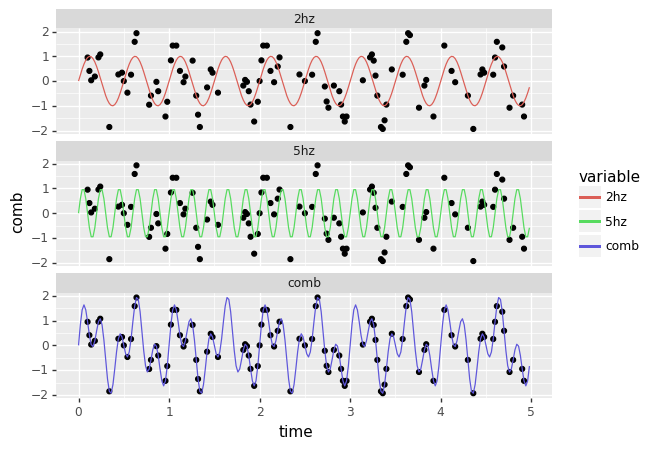

<ggplot: (8726931418423)>

In [30]:
import numpy as np
import pandas as pd
from plotnine import *

np.random.seed(1234)

time_step = 0.02
time_vec = np.arange(0, 5, time_step)
sine_wave = np.sin(2 * np.pi * 5 * time_vec)
sine_wave2 = np.sin(2 * np.pi * 2 * time_vec)

reference_data = pd.DataFrame({'5hz': sine_wave, '2hz': sine_wave2, 'comb': sine_wave + sine_wave2, 'time': time_vec})
observations = reference_data.sample(100)
(
    ggplot(aes(x='time')) 
      + geom_point(observations, aes(y='comb')) 
      + geom_line(reference_data.melt(id_vars='time',  value_vars=['5hz', '2hz', 'comb']), aes(y='value', color='variable'))
      + facet_wrap('~variable', ncol=1)
)

A simple apporach to reconstructing our underlying function would be to use a single sine function: we can either shift the line left or right, or increase the amplitude of the function. But whatever we do, the 2 Hz function will never have a perfect fit with the observations. This is logical, as the observations are drawn from the combined 5 Hz and 2 Hz line. 

To get a good fit, we need to fit a model that combines the 2 Hz and 5 Hz functions. In this case the 2Hz and 5Hz functions are the *basis functions* from which we construct the overall function. In a sesnse, we use an *ensemble* of sine functions to construct one overall more complex function. Using several simpler basis functions to construct much more complex functions is a common approach used for example in Fourier Transforms, wavelets, Neural Networks, Principal Component Analysis, and Taylor expanions. 

# Basis functions need to be simple
The approach of combining simpler basis functions to solve a more complex problem is used by the Gradient Boosting Machine to great effect. The first basis function is the best single node tree, i.e. the model consists of a single yes/no decision tree ([EOSL, page 360](https://hastie.su.domains/ElemStatLearn/)). Consecutive basis functions take the form of trees of size $J$, and are built on the residuals of the previously fitted basis functions. So, the first basis function explains a little bit of the variance in the data, and each extra fitted basis function (subtree) explains more and more of the variance in the data. Each *indivual* basis function (subtree) is not very effective in modeling the data, as we saw with our 2Hz and 5Hz example, and is thus a *weak learner*. The ensemble of weak learners/basis functions however is a very strong learner, which is the core concept on which boosting builds. 

Note that we deliberately create weak learners by limiting the size of the subtree to size $J$ ([EOSL, page 361, section 10.11](https://hastie.su.domains/ElemStatLearn/)). This prevents that the first batch of trees becomes very large, limiting the flexibility we have in fitting later subtrees. We want our basis functions to be *basic*, and let the boosting algorithm do much of the heavy lifting in favor of large individual subtrees. This is very much in line with how neural nets solve problems: very simple mathematical operations that in a large ensemble solve complex problems. The complex solution comes as emergent behavior of the underlying simple operations. 

How a gradient boosting machine calculates the residuals after each subtree is fit sheds further light on why keeping subtrees small is beneficial. My explanation here is heavily inspired by [this SO post](https://stats.stackexchange.com/questions/338658/gradient-in-gradient-boosting). Lets assume that we have a true value $y$ and a value $\hat{y}$ that contains the total prediction of all the previous subtrees we already fitted. Next we construct a new subtree that yields a result $z$, ending up with the total prediction of $\hat{y}+z$. We determine how good our total prediction is using the MSE as our loss function (($L=\frac{1}{2}(y-(\hat{y} + z))$)). The subtree we choose should minimize this loss between $\hat{y}+z$ and $y$. Essentially, $z = y - \hat{y}$ would give us the perfect answer. 

If we use the MSE as our loss function , the gradient of this loss function is $y-\hat{y} = -\frac{\partial L}{\partial \hat{y}}$. We already showed that $y - \hat{y}$ is the optimal answer, so in this case $-\frac{\partial L}{\partial \hat{y}}$ are the targets our new subtree should work towards. So, in fitting each subtree we focus on improving prediction of observations that are still far away from their intended target $y$: i.e. which change in $\hat{y}$ would yield the largest decrease in loss function. In essence we follow the steepest downward trajectory in this prediction space $\hat{y}$, effectively performing gradient descent in this space. This is where the gradient in gradient boosting comes from. I refer to [this link](https://explained.ai/gradient-boosting/descent.html) for a more mathematical derivation of this property of gradient boosting. 

Keeping our steps in the prediction space small during boosting, i.e. using small subtrees, ensures we slowly probe the prediction space surface and don't get stuck in a local minimum. In addition, using small subtrees ensures our consecutive basis functions can specialise in solving specific challenging observations. Using very large trees would promote focusing on overall mean performance in stead of focusing attention on smaller details. Using small trees, and thus weak learners, allows gradient boosting to be very flexible in how to solve the given problem. 

# Conclusion: it takes an ensemble to fit a model
The core concept underlying gradient boosting is to *boost* the effectiveness of a consectutive series (or ensemble) of weak leaners by choosing the next weak learner that minimizes the *gradient* towards the true value. In some sense, a decision tree itself is also a series of weak learners as each subnode can be seen as a small tree in its own right. However, if we fit one big tree the evaluation of the loss function is across the entire tree and the focus is on mean performance, not so much on solving small details in the model. The flexibility and adaptability of gradient boosting is what makes it a very effective way to find a good model, often without much need for tuning of the model. 